# Using Machine Learning to Predict a Pop Song's Subgenre

## Project Background

### Research Question
This project asks the question **“Can we predict a pop song's subgenre using its audio features?”**

### Findings
We found that audio features **can predict** a pop song's subgenre **with 56% accuracy**.

Out of 7 subgenres, there is about a 14% chance of randomly picking the correct subgenre. The model we fit with the Gradient Boost Classifier had the highest accuracy rate of approximately 56%, making it 4 times more likely than random chance to correctly classify a pop song to its correct subgenre.

### Dataset
The dataset was retrieved from Spotify’s API and contains audio feature information for 13,988 pop songs.

### Target Variable
Our target variable is a multi-class categorical variable for 7 pop subgeners:
- 1 = Dance-Pop
- 2 = Rap-Rop
- 3 = Folk-Pop
- 4 = Electro-Pop
- 5 = Rock-Pop
- 6 = Indie-Pop
- 7 = EDM-Pop

### Independent Variables
Our independent variables are audio features - metrics that measure each song's:
- Acousticness
- Danceability
- Duration
- Energy
- Instrumentalness
- Key
- Liveness
- Loudness
- Mode (major or minor key)
- Speechiness
- Tempo
- Time Signature
- Valence

### Modeling with Machine Learning Algorithms
We fit models for the following machine learning algorithms, and used Grid Search Cross Validation to hyper-tune the parameters of each model:
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree Classifier
- Random Forrest Classifier
- AdaBoost Classifier
- Gradient Boost Classifier
- eXtreme Gradient Boost Classifier
- Support Vector Machine

*Not included in our technical notebook: we further tuned each model by: 1) limiting features based on feature importance rankings from Decision Tree Classifier, and 2) applying Principal Component Analysis for dimensionality reduction. Neither of these two adjustments yielded better performing models.*


## Setting Up Dataset

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Autoreload 
%load_ext autoreload
%autoreload 2

#Setting pandas viewing options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

### Importing Datasets

In [2]:
# Import data to Pandas DataFrame
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_final = pd.read_csv('data/test_final.csv')

# Split X & y for train, test, and test_final
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_test_final = test_final.drop('target', axis=1)
y_test_final = test_final['target']


### Scaling Datasets

In [3]:
# Standardize with MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_mmscaled = min_max_scaler.fit_transform(X_train)
X_test_mmscaled = min_max_scaler.transform(X_test)
X_test_final_mmscaled = min_max_scaler.transform(X_test_final)

### Starting a Score List

In [4]:
model_score = {}

## Logistic Regression

In [5]:
from sklearn.utils.class_weight import compute_class_weight

# Computing class weights 
class_names = ['Dance-Pop','Rap-Pop','Folk-Pop', 'Electro-Pop','Rock-Pop', 'Indie-Pop','EDM-Pop']
classes=[1,2,3,4,5,6,7]

class_weights = compute_class_weight(class_weight='balanced',classes=classes,y=y_train)
cls_wt = dict(zip(classes,class_weights))

In [6]:
from sklearn.linear_model import LogisticRegression
from scripts import print_metrics

# Perform baseline logistic regression
logreg_base = LogisticRegression(C = 1e9, 
                                 solver='lbfgs',
                                 multi_class='multinomial', 
                                 max_iter=1000, 
                                 penalty='l2',
                                 class_weight=cls_wt)

logreg_base.fit(X_train_mmscaled, y_train)

pred_logreg_base_train = logreg_base.predict(X_train_mmscaled)
pred_logreg_base_test = logreg_base.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, pred_logreg_base_train, "Train")
print_metrics(y_test, pred_logreg_base_test, "Test")

Train Accuracy Score: 0.4984
Test Accuracy Score: 0.503


### Tuning Logistic Regression Parameters with Grid Search Cross Validation

In [7]:
from sklearn.model_selection import GridSearchCV

logreg_GS = LogisticRegression(random_state = 11,
                               multi_class='multinomial', 
                               max_iter=1000)

# Set grid search params
# Note: these parameters are tuned; best values presented here for speed
param_grid_logreg = [
    {'penalty':['l1'],
     'solver':['saga'],
     'C':[1e9],
     'class_weight':[cls_wt,'balanced']
     },
    {'penalty':['l2'],
     'solver':['newton-cg'],
     'C':[1e9],
     'class_weight':[cls_wt,'balanced']
    }   
]

# Construct grid search
gs_logreg = GridSearchCV(estimator=logreg_GS,
            param_grid=param_grid_logreg,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_logreg.fit(X_train_mmscaled, y_train)

pred_gs_lr_train = gs_logreg.predict(X_train_mmscaled)
pred_gs_lr_test = gs_logreg.predict(X_test_mmscaled)

best_parameters = gs_logreg.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


# Print scores
print_metrics(y_train, pred_gs_lr_train, "Train")
print_metrics(y_test, pred_gs_lr_test, "Test")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   21.6s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.6s finished


Grid Search found the following optimal parameters: 
C: 1000000000.0
class_weight: {1: 0.7974005244555923, 2: 0.7592270950933565, 3: 1.0500713159672697, 4: 1.2655387677553604, 5: 1.081908886998221, 6: 1.4802116402116403, 7: 0.9204448246364414}
penalty: 'l1'
solver: 'saga'
Train Accuracy Score: 0.4984
Test Accuracy Score: 0.5033


In [8]:
# Save scores to model_score list

from sklearn.metrics import accuracy_score
model_score['logreg'] = [accuracy_score(y_train, pred_gs_lr_train),
                         accuracy_score(y_test, pred_gs_lr_test)]

## K-Nearest Neighbors (KNN)

### Fit KNN Model

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier()
knn1.fit(X_train_mmscaled, y_train)
knn1_train_preds = knn1.predict(X_train_mmscaled)
knn1_test_preds = knn1.predict(X_test_mmscaled)

print_metrics(y_train, knn1_train_preds,"Train")
print_metrics(y_test, knn1_test_preds, "Test")

Train Accuracy Score: 0.5869
Test Accuracy Score: 0.4144


### Find Best K by Accuracy

In [10]:
from scripts import find_best_k_acc

find_best_k_acc(X_train_mmscaled, y_train, X_test_mmscaled, y_test)

Best Value for k: 27
Accuracy: 0.44895624821275376


### Fit KNN Model w/ Optimized K=27

In [11]:
knn2 = KNeighborsClassifier(n_neighbors=27)
knn2.fit(X_train_mmscaled, y_train)
knn2_train_preds = knn2.predict(X_train_mmscaled)
knn2_test_preds = knn2.predict(X_test_mmscaled)

# Print Accuracy
print_metrics(y_train, knn2_train_preds,"Train")
print_metrics(y_test, knn2_test_preds,"Test")

Train Accuracy Score: 0.4846
Test Accuracy Score: 0.449


In [12]:
# Save scores to model_score list
model_score['KNN'] = [accuracy_score(y_train, knn2_train_preds),
                      accuracy_score(y_test, knn2_test_preds)]

## Decision Tree Classifier 

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=5) 
tree_clf.fit(X_train_mmscaled, y_train)
tree_pred = tree_clf.predict(X_train_mmscaled)
tree_pred_test = tree_clf.predict(X_test_mmscaled)

# Print Accuracy
print_metrics(y_train, tree_pred,"Train")
print_metrics(y_test, tree_pred_test,"Test")

Train Accuracy Score: 0.442
Test Accuracy Score: 0.4315


In [14]:
#Save scores to model_score list
model_score['Tree'] = [accuracy_score(y_train, tree_pred),
                       accuracy_score(y_test, tree_pred_test)]

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Running a standard random forest 
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth= 5, 
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=11,
                                class_weight='balanced')

forest.fit(X_train_mmscaled, y_train)

pred_forest = forest.predict(X_train_mmscaled)
pred_forest_test = forest.predict(X_test_mmscaled)

print_metrics(y_train, pred_forest,"Train")
print_metrics(y_test, pred_forest_test,"Test")

Train Accuracy Score: 0.5213
Test Accuracy Score: 0.5144


### Random Forest Parameter Tuning

In [17]:
# Using Grid Search and Cross Validation

forest_GS = RandomForestClassifier(random_state = 11,
                                   bootstrap=True,
                                   n_jobs=-1,
                                   oob_score=True,
                                   class_weight='balanced')

# Set grid search params
# Note: these parameters are tuned; best values presented here for speed
param_grid_forest = [ 
  {'n_estimators': [225],
   'criterion': ['entropy'], 
   'max_depth': [8],  
   'min_samples_leaf':[1]  
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=forest_GS,
            param_grid=param_grid_forest,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_rf.fit(X_train, y_train)

pred_gs_rf_train = gs_rf.predict(X_train)
pred_gs_rf_test = gs_rf.predict(X_test)

best_parameters = gs_rf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Grid Search found the following optimal parameters: 
criterion: 'entropy'
max_depth: 8
min_samples_leaf: 1
n_estimators: 225
Best accuracy: 0.533


In [18]:
print_metrics(y_train, pred_gs_rf_train,"Train")
print_metrics(y_test, pred_gs_rf_test,"Test")

Train Accuracy Score: 0.6047
Test Accuracy Score: 0.5416


In [19]:
#Save scores to model_score list
model_score['Forest'] = [accuracy_score(y_train, pred_gs_rf_train),
                         accuracy_score(y_test, pred_gs_rf_test)]

## AdaBoost Classifier

In [20]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train_mmscaled, y_train)

# Create predictions
adaboost_train_preds = adaboost_clf.predict(X_train_mmscaled)
adaboost_test_preds = adaboost_clf.predict(X_test_mmscaled)

print_metrics(y_train, adaboost_train_preds, "Train")
print_metrics(y_test, adaboost_test_preds, "Test")

Train Accuracy Score: 0.5031
Test Accuracy Score: 0.4984


### AdaBoost Classifier Parameter Tuning

In [25]:
adaboost_GS = AdaBoostClassifier(algorithm='SAMME.R',
                                 random_state=11)
 
# Set grid search parameters
# Note: these parameters are tuned; best values presented here for speed
param_grid_adaboost = [ 
  {'base_estimator':[DecisionTreeClassifier(max_depth=2)],
   'learning_rate': [0.1],
   'n_estimators': [300]
  }
]

# Construct grid search
gs_ab = GridSearchCV(estimator=adaboost_GS,
            param_grid=param_grid_adaboost,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_ab.fit(X_train_mmscaled, y_train)

# Create predictions
pred_gs_ab_train = gs_ab.predict(X_train_mmscaled)
pred_gs_ab_test = gs_ab.predict(X_test_mmscaled)

# Print scores
print_metrics(y_train, pred_gs_ab_train, "Train")
print_metrics(y_test, pred_gs_ab_test, "Test")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Train Accuracy Score: 0.554
Test Accuracy Score: 0.5402


In [26]:
# Save scores to model_score list
model_score['AdaBoost'] = [accuracy_score(y_train, pred_gs_ab_train), 
                           accuracy_score(y_test, pred_gs_ab_test)]

## Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train_mmscaled, y_train)

# Create predictions
gbt_clf_train_preds = gbt_clf.predict(X_train_mmscaled)
gbt_clf_test_preds = gbt_clf.predict(X_test_mmscaled)

# Print scores
print_metrics(y_train, gbt_clf_train_preds, "Train")
print_metrics(y_test, gbt_clf_test_preds, "Test")

Train Accuracy Score: 0.6227
Test Accuracy Score: 0.5525


### Tuning Gradient Boosting Parameters using Grid Search and Cross Validation

In [28]:
gb_GS = GradientBoostingClassifier(random_state=11, max_features='auto')

# Set grid search params
# Note: these parameters are tuned; best values presented here for speed

param_grid_gboost = [ 
  {'subsample': [0.8],
   'learning_rate': [0.055],
   'n_estimators': [360],
   'max_depth':[2]
  }
]

# Construct grid search
gs_gradboost = GridSearchCV(estimator=gb_GS,
               param_grid=param_grid_gboost,
               scoring='accuracy',
               refit='accuracy',
               cv=5, verbose=2, return_train_score = True,
               n_jobs=-1)

# Fit using grid search
gs_gradboost.fit(X_train_mmscaled, y_train)

pred_gs_gb_train = gs_gradboost.predict(X_train_mmscaled)
pred_gs_gb_test = gs_gradboost.predict(X_test_mmscaled)


# Best parameters
best_parameters = gs_gradboost.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

#Print scores
print_metrics(y_train, pred_gs_gb_train, "Train")
print_metrics(y_test, pred_gs_gb_test, "Test")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


Grid Search found the following optimal parameters: 
learning_rate: 0.055
max_depth: 2
n_estimators: 360
subsample: 0.8
Train Accuracy Score: 0.6087
Test Accuracy Score: 0.5653


In [29]:
#Save scores to model_score list
model_score['Gradient Boost'] = [accuracy_score(y_train, pred_gs_gb_train),
                                 accuracy_score(y_test, pred_gs_gb_test)]

## eXtreme Gradient Boost Classifier (XGBoost)

In [30]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_mmscaled, y_train)
xgb_pred_train = xgb_clf.predict(X_train_mmscaled)
xgb_pred_test = xgb_clf.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, xgb_pred_train, "Train")
print_metrics(y_test, xgb_pred_test, "Test")

Train Accuracy Score: 0.5946
Test Accuracy Score: 0.5479


### Tuning XGBoost Parameters using Grid Search and Cross Validation

In [32]:
# Tuning XGBoost
from sklearn.model_selection import GridSearchCV

# Note: these parameters are tuned; best values presented here for speed
xgb_param_grid = {
    "learning_rate": [0.06],
    'max_depth': [2],
    'subsample': [0.75],
    'n_estimators': [400],
}

grid_xgb_clf = GridSearchCV(xgb_clf, 
                            xgb_param_grid, 
                            scoring='accuracy', 
                            cv=5, 
                            n_jobs=-1)

grid_xgb_clf.fit(X_train_mmscaled, y_train)

pred_gs_gxb_train = grid_xgb_clf.predict(X_train_mmscaled)
pred_gs_gxb_test = grid_xgb_clf.predict(X_test_mmscaled)

best_parameters = grid_xgb_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# Print scores
print_metrics(y_train, pred_gs_gxb_train, "Train")
print_metrics(y_test, pred_gs_gxb_test, "Test")

Grid Search found the following optimal parameters: 
learning_rate: 0.06
max_depth: 2
n_estimators: 400
subsample: 0.75
Train Accuracy Score: 0.5887
Test Accuracy Score: 0.5593


In [33]:
# Save scores to model_score list
model_score['XGBoost'] = [accuracy_score(y_train, pred_gs_gxb_train), 
                          accuracy_score(y_test, pred_gs_gxb_test)]

## SVM

In [34]:
from sklearn import svm
svm_clf = svm.SVC(probability=True, random_state=11)
svm_clf.fit(X_train_mmscaled, y_train)

pred_svm_train = gs_logreg.predict(X_train_mmscaled)
pred_svm_test = gs_logreg.predict(X_test_mmscaled)

# Print scores
print_metrics(y_train, pred_svm_train, "Train")
print_metrics(y_test, pred_svm_test, "Test")

Train Accuracy Score: 0.4984
Test Accuracy Score: 0.5033


### Tuning SVM Parameters using Grid Search and Cross Validation

In [35]:
# Set grid search params
# Note: these parameters are tuned; best values presented here for speed
param_grid_svm = [
    #{'C': [12], 'kernel': ['linear']},
    #{'C': [10], 'gamma': [0.1], 'kernel': ['rbf']},
    {'coef0': [25], 'gamma': [0.03], 'degree': [3], 'kernel': ['poly']},
    #{'coef0': [0.01], 'gamma': [0.2], 'kernel': ['sigmoid']}
]

# Construct grid search
gs_svm = GridSearchCV(estimator=svm_clf,
           param_grid=param_grid_svm,
           scoring='accuracy',
           cv=3, verbose=2, return_train_score=True,
                     n_jobs=5)

# Fit using grid search
gs_svm.fit(X_train_mmscaled, y_train)

pred_gs_svm_train = gs_svm.predict(X_train_mmscaled)
pred_gs_svm_test = gs_svm.predict(X_test_mmscaled)

best_parameters = gs_svm.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# Print scores
print_metrics(y_train, pred_gs_svm_train, "Train")
print_metrics(y_test, pred_gs_svm_test, "Test")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:   27.9s finished


Grid Search found the following optimal parameters: 
coef0: 25
degree: 3
gamma: 0.03
kernel: 'poly'
Train Accuracy Score: 0.5154
Test Accuracy Score: 0.5104


In [36]:
# Save scores to model_score list
model_score['SVM'] = [accuracy_score(y_train, pred_gs_svm_train),
                      accuracy_score(y_test, pred_gs_svm_test)]

## Choosing the best model 

In [37]:
scores = pd.DataFrame(model_score,index=['Train','Test']).T
scores

,Train,Test
logreg,0.498427,0.503289
KNN,0.484558,0.448956
Tree,0.441950,0.431513
Forest,0.604661,0.541607
AdaBoost,0.553975,0.540177
Gradient Boost,0.608665,0.565342
XGBoost,0.588719,0.559337
SVM,0.515370,0.510438


The model fit with Gradient Boost Classifier had the highest accuracy rate of 56.5%. This is the model we chose moving forward. 

## Fitting Test_Final Dataset 

In [38]:
# Create prediction with Gradient Boost 
gb_pred_test_final = gs_gradboost.predict(X_test_final_mmscaled)

# Print accuracy
print_metrics(y_test_final, gb_pred_test_final, "Final Test")

Final Test Accuracy Score: 0.5577


### Confusion Matrix

Confusion matrix, without normalization


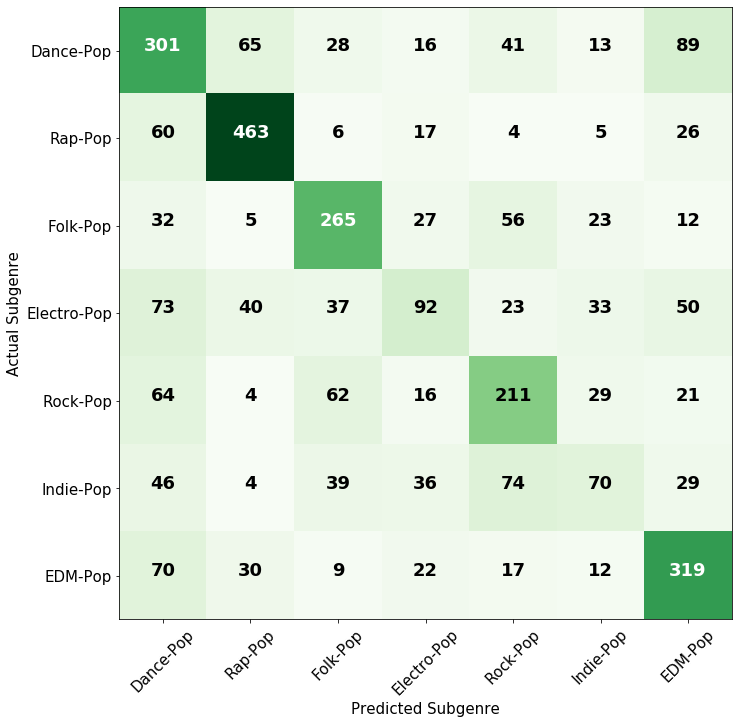

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scripts import plot_confusion_matrix 
%matplotlib inline

cnf_matrix = confusion_matrix(y_test_final, gb_pred_test_final)

plot_confusion_matrix(cm=cnf_matrix, classes=class_names)

plt.savefig('images/confusion_matrix.png',bbox_inches='tight')

### Feature Importance 

In [40]:
from scripts import plot_feature_importances

gb_model = GradientBoostingClassifier(random_state=11, 
                                      max_features='auto',
                                      learning_rate=0.055,
                                      max_depth=2,
                                      n_estimators= 360,
                                      subsample= 0.8)

gb_model.fit(X_train_mmscaled, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.055, loss='deviance', max_depth=2,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=360,
                           n_iter_no_change=None, presort='auto',
                           random_state=11, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [41]:
# Seven most important features

top_feats = zip(gb_model.feature_importances_,X_train.columns.values)
topfeat=list(top_feats)

sorted(topfeat, key=lambda x:(x[0],x[1]), reverse=True)[:7]

[(0.27803934543357023, 'speechiness'),
 (0.11269869021126015, 'danceability'),
 (0.11221382141329816, 'acousticness'),
 (0.10249096956781968, 'energy'),
 (0.10234173001020694, 'instrumentalness'),
 (0.07918427560621934, 'valence'),
 (0.06635922618941342, 'loudness')]

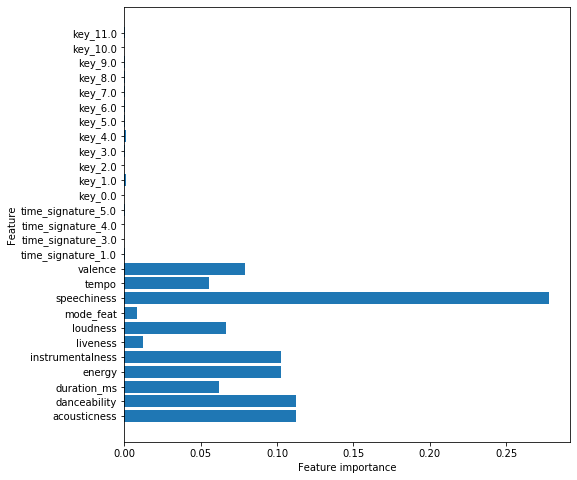

In [42]:
# Plot feature importance

plot_feature_importances(gb_model, X_train)
plt.savefig('images/feature_importance',bbox_inches='tight');

### Presentation Songs 

In [43]:
pres_test = pd.read_csv('data/presentation_test.csv')
pres_test = pres_test.iloc[:,1:]
pres_test_scaled = min_max_scaler.transform(pres_test)
pres_test

pres_y = [1,2,3,4,5,6,7]

pred_present_gb = gs_gradboost.predict(pres_test)
print(f"Song predictions: {pred_present_gb}")

print_metrics(pres_y, pred_present_gb, "GradBoost")

Song predictions: [1 2 3 5 5 5 2]
GradBoost Accuracy Score: 0.5714
